In [4]:
# import dependencies
import os, re, random
import numpy as np
import pandas as pd
from tqdm import tqdm

import spacy
from spacy import displacy
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# set deterministic seed
random.seed(42); np.random.seed(42)
tqdm.pandas()

# Load Note Events, Diagnoses ICD and Dict tables

Load the data necessary to build models. I included the `D_ICD_DIAGNOSES` table just so I could see the description of the ICD9 codes.

In [7]:
# load tables
NOTE_EVENTS_PATH = "../mimic-iii/NOTEEVENTS.csv.gz"
df_noteevents = pd.read_csv(NOTE_EVENTS_PATH, compression='gzip')
df_noteevents.info()

DIAGNOSES_PATH = "../mimic-iii/DIAGNOSES_ICD.csv.gz"
df_diagnoses_icd = pd.read_csv(DIAGNOSES_PATH, compression='gzip', dtype={'SEQ_NUM': 'Int64'})
df_diagnoses_icd.info()

DIAG_DICT_PATH = "../mimic-iii/D_ICD_DIAGNOSES.csv.gz"
df_diagnoses_dict = pd.read_csv(DIAG_DICT_PATH, compression='gzip', dtype={'SEQ_NUM': 'Int64'})
df_diagnoses_dict.info()

/var/folders/n2/79rl6kvj3lq1qfjnjpy7zspc0000gn/T/ipykernel_58110/969203306.py:3: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_noteevents = pd.read_csv(NOTE_EVENTS_PATH, compression='gzip')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ROW_ID      651047 non-null  int64 
 1   SUBJECT_ID  651047 non-null  int64 
 2   HADM_ID     651047 non-null  int64 
 3   SEQ_NUM     651000 non-null  Int64 
 4   ICD9_CODE   651000 non-null  object
dtypes: Int64(1), int64(3), object(1)
memory usage: 25.5+ MB
<class 'pandas.core.frame.D

# Determine diagnoses on which to focus

Choose a diagnoses to focus on by listing the more common diagnoses, but choosing one with a manageable number of corresponding admission records.

In [9]:
# display the top 20 most common diagnoses
top_icd9_counts = df_diagnoses_icd['ICD9_CODE'].value_counts().head(20)
print("Top 10 ICD9_CODE counts:")
for code, count in top_icd9_counts.items():
    print(f"{code} ({df_diagnoses_dict[df_diagnoses_dict['ICD9_CODE'] == code]['SHORT_TITLE'].values[0]}): {count}")

# filter rows with ICD9_CODE
ICD_FILTER = ['99592']
df_filtered = df_diagnoses_icd[df_diagnoses_icd['ICD9_CODE'].isin(ICD_FILTER)]
admissions_with_diagnoses = df_filtered['HADM_ID'].unique()
print(f"Number of ICD-9 {ICD_FILTER} admissions: {admissions_with_diagnoses.size}")

# filter notes for admissions with diagnoses
df_noteevents_filtered = df_noteevents[df_noteevents['HADM_ID'].isin(admissions_with_diagnoses)]
df_noteevents_filtered.info()

df_noteevents_filtered['CATEGORY'].unique()
df_diag_notes = df_noteevents_filtered[df_noteevents_filtered['CATEGORY'] == 'Respiratory ']
df_diag_notes.info()



Top 10 ICD9_CODE counts:
4019 (Hypertension NOS): 20703
4280 (CHF NOS): 13111
42731 (Atrial fibrillation): 12891
41401 (Crnry athrscl natve vssl): 12429
5849 (Acute kidney failure NOS): 9119
25000 (DMII wo cmp nt st uncntr): 9058
2724 (Hyperlipidemia NEC/NOS): 8690
51881 (Acute respiratry failure): 7497
5990 (Urin tract infection NOS): 6555
53081 (Esophageal reflux): 6326
2720 (Pure hypercholesterolem): 5930
V053 (Need prphyl vc vrl hepat): 5779
V290 (NB obsrv suspct infect): 5519
2859 (Anemia NOS): 5406
2449 (Hypothyroidism NOS): 4917
486 (Pneumonia, organism NOS): 4839
2851 (Ac posthemorrhag anemia): 4552
2762 (Acidosis): 4528
496 (Chr airway obstruct NEC): 4431
99592 (Severe sepsis): 3912
Number of ICD-9 ['99592'] admissions: 3912
<class 'pandas.core.frame.DataFrame'>
Index: 239980 entries, 26 to 2066679
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ROW_ID       239980 non-null  int64  
 1   SUBJECT_ID   2

# Examine Respiratory Notes for Severe Sepsis

I chose Severe Sepsis diagnosis, focusing on notes under the Respiratory category. This yielded `9895` entries.

## Load SpaCy and SciSpaCy Models

For comparison, I'm using the general model `en_core_web_sm` and `scispacy` model `en_core_sci_md`.

In [10]:
nlp_gen = spacy.load("en_core_web_sm")
nlp_sci_md = spacy.load("en_core_sci_md")

/Users/seth/code/msai/msai-54315-ai-for-healthcare/assignment-3-mimic-nlp/.venv/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/Users/seth/code/msai/msai-54315-ai-for-healthcare/assignment-3-mimic-nlp/.venv/lib/python3.9/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


## Extract Entities

Define a function that can be reused to extract entities using any `spacy` model

In [12]:
# define function to extract entities
def extract_ents(nlp, texts, batch_size=128):
    docs = []
    # only run the NER pipe for speed
    with nlp.select_pipes(enable=["ner"]):
        for doc in tqdm(
            nlp.pipe(texts, batch_size=batch_size),
            total=len(texts), desc=f"NER ({nlp.meta.get('name','model')})"
        ):
            docs.append(doc)
    return docs



Use the function to extract entities with the two loaded models

In [15]:
notes = df_diag_notes["TEXT"].tolist()
ents_gen = extract_ents(nlp_gen, notes)
ents_sci = extract_ents(nlp_sci_md, notes)

NER (core_web_sm):   0%|          | 0/9895 [00:00<?, ?it/s]

NER (core_sci_md): 100%|██████████| 9895/9895 [02:13<00:00, 73.93it/s]


In [16]:
# show entities for first text sample from each model
displacy.render(ents_gen[0], style="ent", jupyter=True)
displacy.render(ents_sci[0], style="ent", jupyter=True)

## Generate Corpus

For each set of entities, generate a corpus. Wrote a function that can be used for any output of a spacy model pipeline.

In [18]:
import re
def get_corpus(docs):
    corpus = []
    for doc in docs:
        ents = []
        for ent in doc.ents:
            # normalize entity string -> lowercase, keep only letters/digits/spaces,
            e = re.sub(r"[^a-zA-Z0-9\s]", " ", ent.text.lower()).strip()
            if len(e) > 2:
                ents.append(e)
        corpus.append(ents)
    return corpus

corpus_gen = get_corpus(ents_gen)
corpus_sci = get_corpus(ents_sci)

print(len(corpus_gen[0]))
print(len(corpus_sci[0]))


28
95


## Train Word2Vec Models on each Corpus

In [20]:
from gensim.models import Word2Vec
model_gen = Word2Vec(corpus_gen, vector_size=100, window=5, min_count=1, workers=4)
model_sci = Word2Vec(corpus_sci, vector_size=100, window=5, min_count=1, workers=4)

model_gen.wv.most_similar("asthma")
model_sci.wv.most_similar("asthma")


[('weak', 0.9920033812522888),
 ('pmh', 0.9899781942367554),
 ('precautions', 0.9899569153785706),
 ('transfused', 0.9891850352287292),
 ('copd', 0.9891129732131958),
 ('insp time', 0.9889084696769714),
 ('plateaus', 0.9887712001800537),
 ('rrt', 0.9886153936386108),
 ('albuterol atrovent', 0.9880446195602417),
 ('v tach', 0.9875922799110413)]

## Plot t-SNE

Using a modified `tsne_plot()` function from the tutorial, plot the dimension-reduced vectors created by Word2Vec.

In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def tsne_plot(model,words, showLabels=True, preTrained=False):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in words:
      if preTrained:
          tokens.append(model[word])
      else:
          tokens.append(model.wv[word])
      if showLabels:
        labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        if showLabels:
            plt.annotate(labels[i],
                        xy=(x[i], y[i]),
                        xytext=(5, 2),
                        textcoords='offset points',
                        ha='right',
                        va='bottom')
    plt.show()


### Clusters for SpaCy Corpus

t-SNE plot of the corpus generated using the general `spacy` model.

/Users/seth/code/msai/msai-54315-ai-for-healthcare/assignment-3-mimic-nlp/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


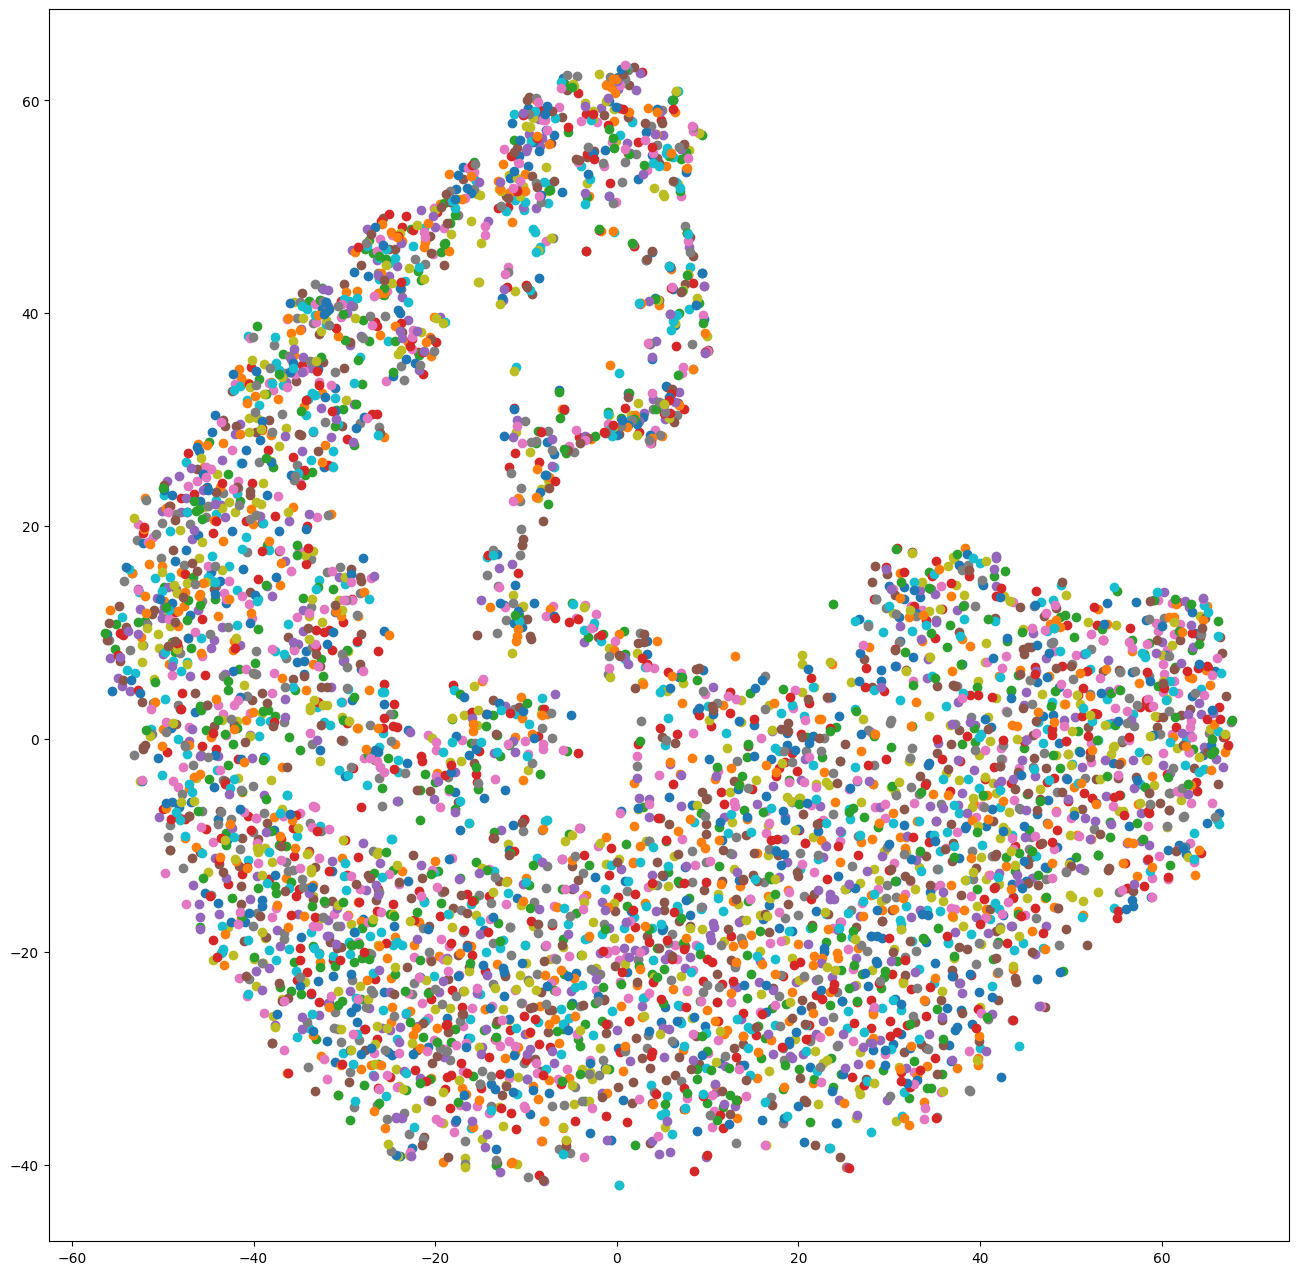

In [22]:
gen_vocabs = model_gen.wv.key_to_index.keys()
tsne_plot(model_gen,gen_vocabs, showLabels=False)


### Clusters for SciSpaCy Corpus

t-SNE plot of the corpus generated using the `scispacy` model.

/Users/seth/code/msai/msai-54315-ai-for-healthcare/assignment-3-mimic-nlp/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


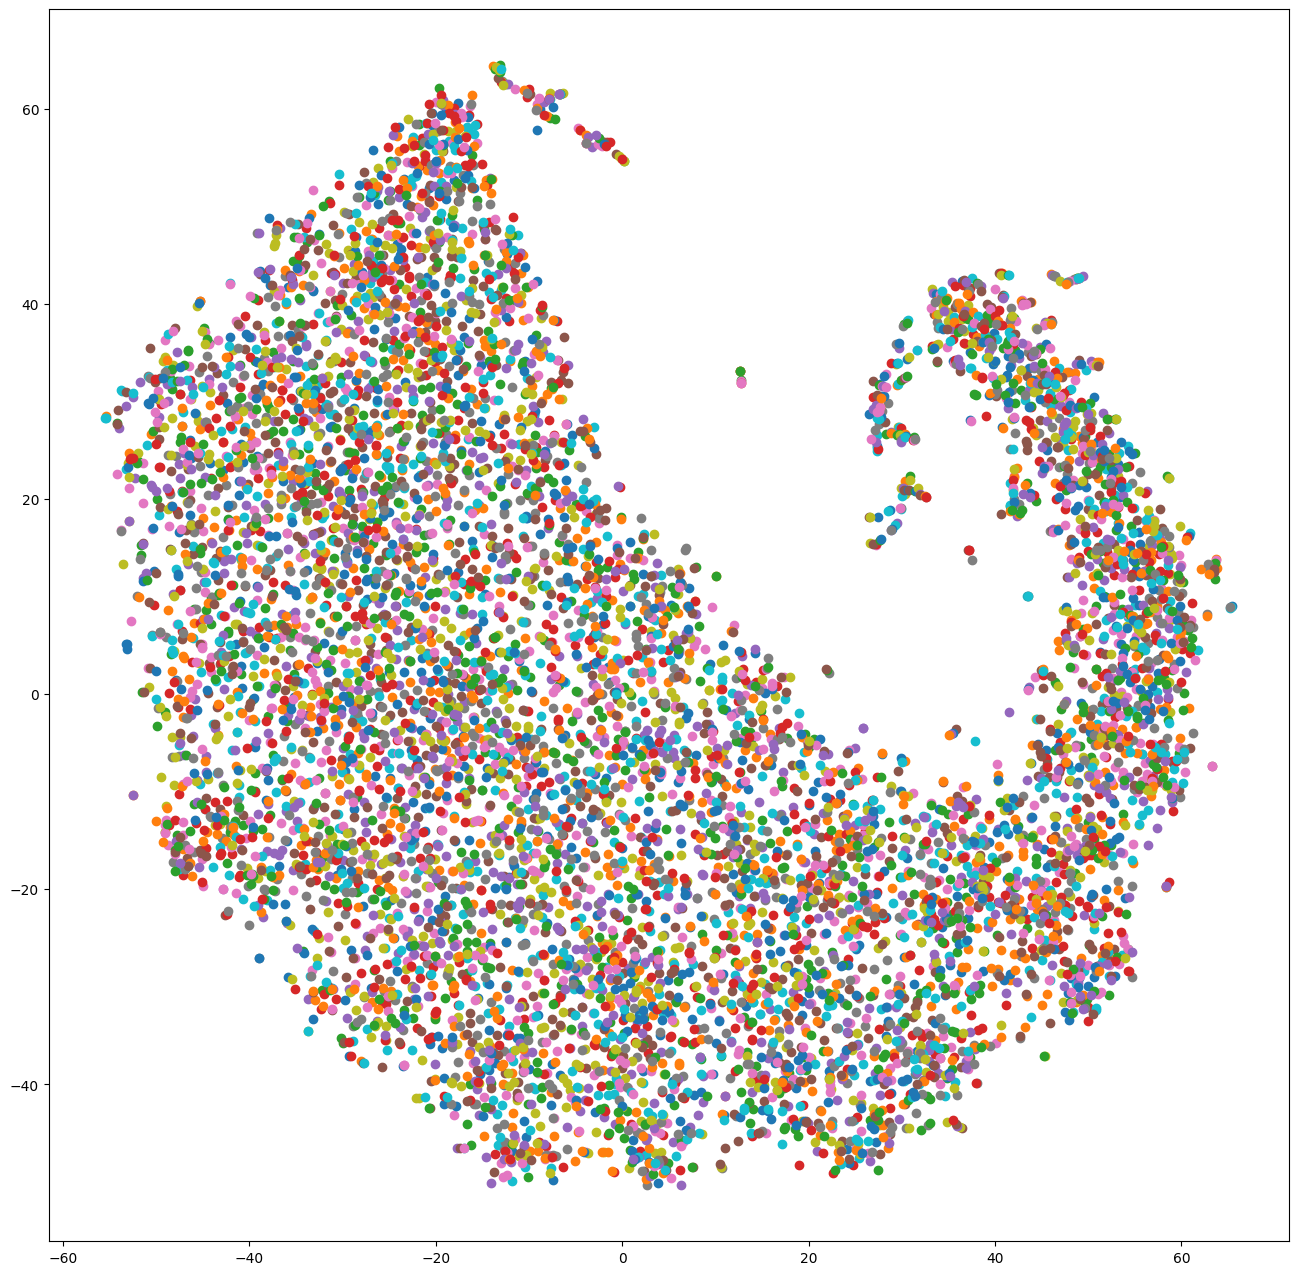

In [24]:
sci_vocabs = model_sci.wv.key_to_index.keys()
tsne_plot(model_sci,sci_vocabs, showLabels=False)


## Bonus – Using Transformers NER pipeline with biomedical model

Apply the same process with Hugging Face Transformer

Device set to use cpu
NER (HF biomedical): 100%|██████████| 619/619 [04:17<00:00,  2.40it/s]
/Users/seth/code/msai/msai-54315-ai-for-healthcare/assignment-3-mimic-nlp/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


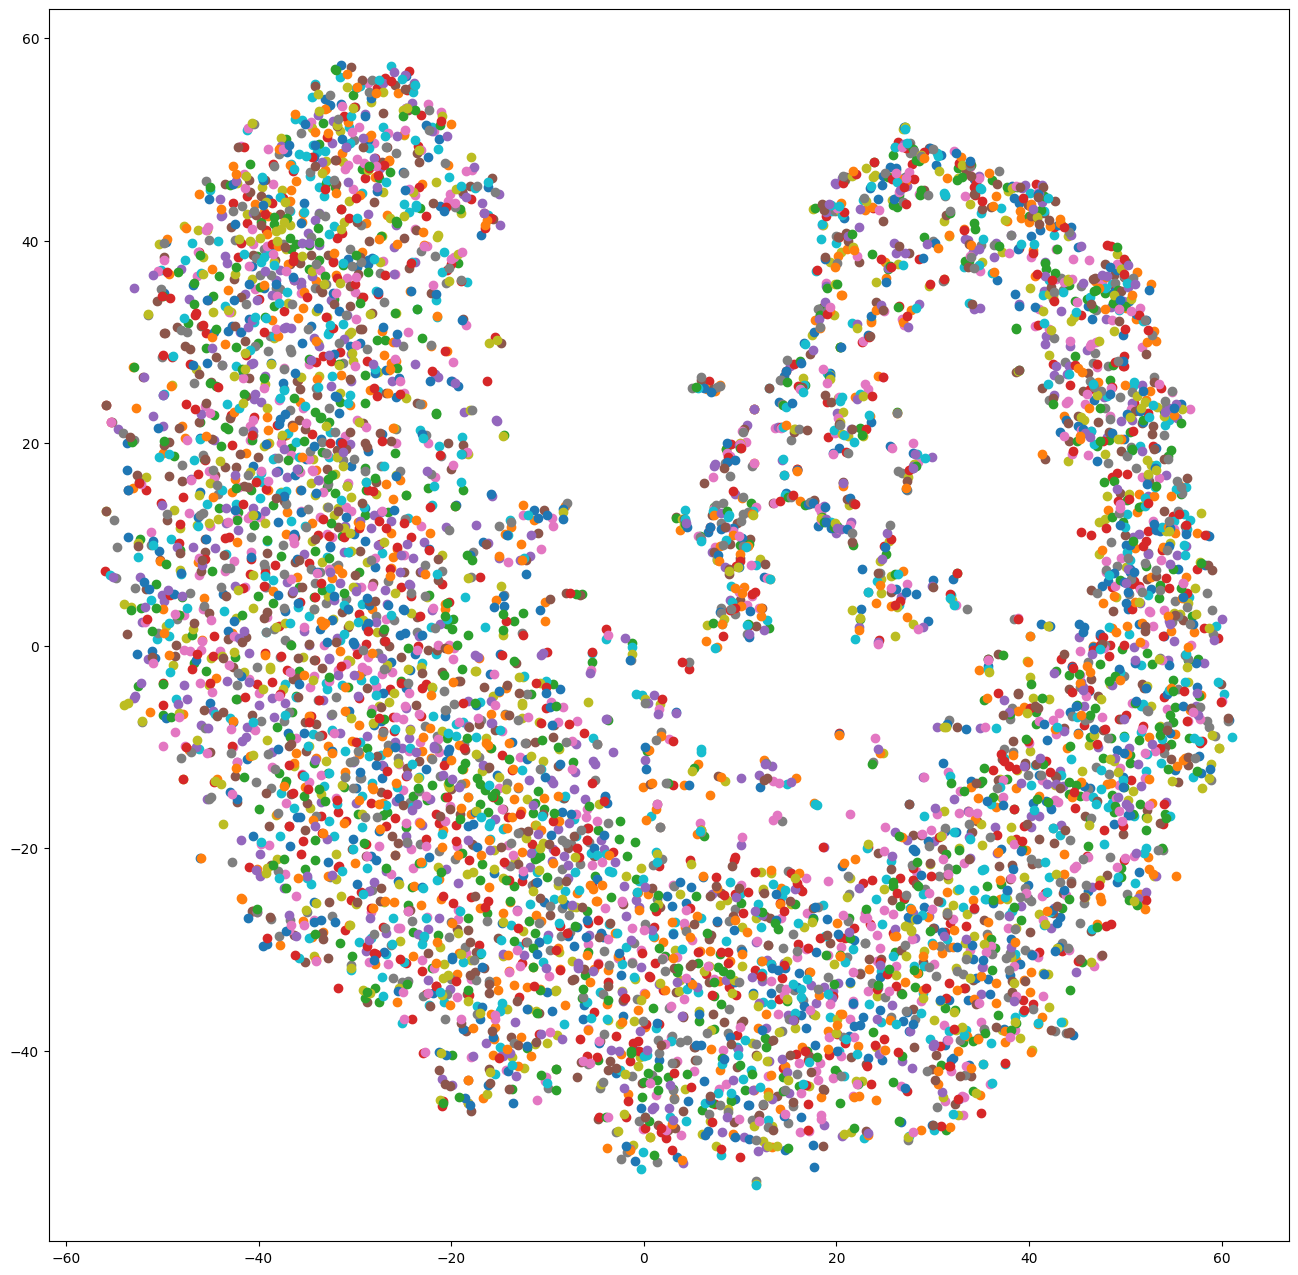

In [26]:
from transformers import pipeline

# create a biomedical NER pipeline
# d4data/biomedical-ner-all is a solid, general biomedical NER model
ner_pipe = pipeline(
    "ner",
    model="d4data/biomedical-ner-all",
    aggregation_strategy="simple",  # groups wordpieces
    device=-1                       # CPU
)

# batch-run NER on text samples
def extract_ents_hf(texts, batch_size=16):
    """
    Returns list of "docs", where each doc mimics spaCy-ish .ents as a list of dicts:
      {"text": "...", "label_": "..."}
    """
    docs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="NER (HF biomedical)"):
        batch = texts[i:i+batch_size]
        # transformers pipeline supports list input directly
        outputs = ner_pipe(batch)
        # outputs is a list per input text
        for ents in outputs:
            docs.append([{"text": e["word"], "label_": e["entity_group"]} for e in ents])
    return docs

ents_hf = extract_ents_hf(notes)

def get_corpus_from_hf(docs):
    corpus = []
    for ents in docs:
        toks = []
        for e in ents:
            t = re.sub(r"[^a-z0-9\s]", " ", e["text"].lower()).strip()
            if len(t) > 2:
                toks.append(t)
        corpus.append(toks)
    return corpus

corpus_hf = get_corpus_from_hf(ents_hf)

# train Word2Vec and plot
model_hf = Word2Vec(corpus_hf, vector_size=100, window=5, min_count=1, workers=4)

hf_vocabs = model_hf.wv.key_to_index.keys()
tsne_plot(model_hf, hf_vocabs, showLabels=False)